# CASF-2013x2016 testing

In [1]:
### basic imports ###
import os
import _pickle as pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,Normalizer
import time

In [2]:
### some useful function ###

def getImportance(model, feature_list, top_n=20):
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:top_n]]
    return ['Variable: {:20} Importance: {}'.format(*pair) for pair in feature_importances[:top_n]]

def getPerformance(predictions, test_labels):
    correlation = np.corrcoef(predictions, test_labels)
    errors = abs(predictions -test_labels)
    mae = round(np.mean(errors),2)
    mape = 100*(errors/test_labels)
    accuracy = 100 - np.mean(mape)
    rmse = round(np.sqrt(np.mean(np.square(predictions -test_labels))),3)
    perfs = {'correlation':correlation,'errors':errors, 'mae':mae, 'mape':mape, 'rmse': rmse,'accuracy':accuracy}

    return perfs

def printPerformance(prd, casf2016PKD,mlType=''):
    casf2016corrcoefficient = round(np.corrcoef(prd, casf2016PKD)[1][0],3)
    casf2016perfs = getPerformance(prd, casf2016PKD)
    if mlType:
        print(f"{mlType} performance:")
        
    print(f"Correlation Coefficient: R={casf2016corrcoefficient}")
    print(f"Accuracy: {round(casf2016perfs['accuracy'],3)}")
    print(f"Mean absolute error: {round(casf2016perfs['mae'],3)}")
    print(f"Standard error of the errors: {round(np.std(casf2016perfs['errors']),3)}")
    print(f"RMSE: {round(casf2016perfs['rmse'],3)}\n")

def readCasfIndex(indexPath):
    proteinList = []
    with open(indexPath, 'r') as fi:
        lines = fi.readlines()
        for line in lines:
            if line.startswith('#')==False:
                proteinList.append(line.split()[0])
    return proteinList

# automatize training and testing of 4 different model: 
# Random Forest, SVM, linear regression, KNN

def batchMlExecution(X_train, y_train, X_test, y_test):
    from sklearn import neighbors
    from sklearn.svm import SVR
    from sklearn.linear_model import LinearRegression
    
    scaler = StandardScaler().fit(X_train)
    standardizedFeatures = scaler.transform(X_train)
    standardizedTest = scaler.transform(X_test)

    svr =  SVR()
    rf = RandomForestRegressor(n_estimators=100,n_jobs=10)
    lr = LinearRegression(normalize=True)
    knn = neighbors.KNeighborsRegressor(n_neighbors=10)
    
    svr.fit(standardizedFeatures, y_train)
    rf.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    
    svrPred = svr.predict(standardizedTest)
    rfPred = rf.predict(X_test)
    lrPred = lr.predict(X_test)
    knnPred = knn.predict(X_test)
    
    svrPerf = getPerformance(svrPred, y_test)
    rfPerf = getPerformance(rfPred, y_test)
    lrPerf = getPerformance(lrPred, y_test)
    knnPerf = getPerformance(knnPred, y_test)
    
    return svrPerf, rfPerf, lrPerf, knnPerf

def plotCorr(prediction, y_test):
    matplotlib.style.use('seaborn-ticks')
    #vina R= 604
    slope, intercept = np.polyfit(prediction, y_test, 1)
    abline_values = [slope * i + intercept for i in prediction]
    plt.scatter(prediction, y_test, s=40, edgecolors='black')
    plt.plot(prediction, abline_values, 'r',linewidth=5)
    plt.gcf().set_size_inches((10,10))
    plt.xticks(range(0,16,3), fontsize=22)
    plt.yticks(range(0,16,3), fontsize=22)
    plt.xlabel('Predicted pKd')
    plt.ylabel('Experimental pKd')
    plt.show()

def preparingTrainingSet(inputFeatures, affinityLables, testSetPDBlist, mask=False):
    """
    arguments:
        inputFeatures: pandas DataFrame
            input dataframe of features
        affinityLabels: Dict
            dictionary referring to the experimental binding affinity of each ligand
        tesSetPDBlist: list
            list of pdb belonging to the test set, for filtering reasons
        mask: list
            additional pdb to remove
        
    """
    if mask:
        X_train = inputFeatures[inputFeatures['pdb'].isin(mask)]
    else:
        X_train = inputFeatures
    X_train = X_train[~X_train['pdb'].isin(testSetPDBlist)]
    X_train = X_train.fillna(0)
    
    print(f"Number of samples in training set {len(X_train)}")
    
    #saving labels
    y_train = [affinityLabels[x] for x in X_train['pdb']]
    
    X_train = X_train.drop('pdb', axis = 1)
    X_train = X_train.drop('Affinity', axis = 1)

    
    for feat in X_train.columns:
        if X_train[feat].std() == 0.0:
            X_train.drop(feat, axis = 1, inplace=True)

    X_train = X_train.reindex(sorted(X_train.columns), axis=1)
    return X_train,y_train

def preparingTestSet(X_train, testSet):
    X_test = testSet
    y_test = [affinityLabels[x] for x in testSet['pdb']]
        
    X_test = X_test.fillna(0)
    X_test = X_test.drop('pdb', axis = 1)
    X_test = X_test.drop('Affinity', axis = 1)

    for feat in X_test.columns:
        if feat not in X_train.columns:
            X_test.drop(feat, axis = 1, inplace = True)
       
    X_test = X_test.reindex(sorted(X_test.columns), axis=1)

    print(f"Number of sample in test set: {len(X_test)}")
    return X_test, y_test

In [3]:
### import precalculated features ###
import _pickle as pickle

with open("/home/poltix/PDBBind/PDBBindAffinityAll.pickle", 'rb') as fi:
    affinityLabels = pickle.load(fi)

# new dataset comprehend all the PDBBind2018
with open('/home/poltix/Documents/pdbbind2018.pickle', 'rb') as fi:
    pdbbind2018Features = pickle.load(fi)

with open('/home/poltix/Documents/casf_2016_index.txt','r') as fi:
    lines = fi.readlines()
     
casf2016dict = {line.split(' ')[1].lower():float(line.split(' ')[2]) for line in lines}
casf2016 = list(casf2016dict)
casf2013 = readCasfIndex('/home/poltix/CASF-2013-up/coreset/index/2013_core_data.lst')

# merge all the complexes in a single non redundant set
casfAll = []
#casfAll.extend(casf2007)
casfAll.extend(casf2013)
casfAll.extend(casf2016)
casfAll = list(set(casfAll))
len(casfAll)

373

In [4]:
#pdbb2018Index = readCasfIndex('/home/poltix/PDBBind/index/INDEX_refined_data.2018')
with open('/home/poltix/Scrivania/Spyder/phCo_revision/pdbFiltered40.txt', 'r') as fi: identityMask40 = fi.read().splitlines()
with open('/home/poltix/Scrivania/Spyder/phCo_revision/pdbFiltered50.txt', 'r') as fi: identityMask50 = fi.read().splitlines()
with open('/home/poltix/Scrivania/Spyder/phCo_revision/pdbFiltered70.txt', 'r') as fi: identityMask70 = fi.read().splitlines()
with open('/home/poltix/Scrivania/Spyder/phCo_revision/pdbFiltered90.txt', 'r') as fi: identityMask90 = fi.read().splitlines()
with open('/home/poltix/Scrivania/Spyder/phCo_revision/pdbFiltered100.txt', 'r') as fi: identityMask100 = fi.read().splitlines()


In [5]:
with open('/home/poltix/Documents/casf2013WMetalIon.pickle', 'rb') as fi:
    df2013 = pickle.load(fi)
with open('/home/poltix/Documents/casf2016WMetalIon.pickle', 'rb') as fi:
    df2016 = pickle.load(fi)

print(df2013.shape)
print(df2016.shape)
dfnr = df2013[~df2013['pdb'].isin(df2016['pdb'])]
print(dfnr.shape)
dfAll = df2016.append(dfnr,ignore_index = True)
print(dfAll.shape)
print(dfAll.shape)
dfAll.head()

(192, 911)
(285, 911)
(85, 911)
(370, 911)
(370, 911)


,AR_ARp_1,AR_ARp_2,AR_ARp_3,AR_ARp_4,AR_ARp_5,AR_ARp_6,AR_ARp_7,AR_ARp_8,AR_ARp_9,AR_Ap_1,...,P_Pp_7,P_Pp_8,P_Pp_9,bligand,bprotein,gauss 1,gauss 2,hydrophobic,repulsion,pdb
0,0,32,4,17,57,46,38,77,92,0,...,0,0,0,470.289098,194.579543,112.34222,1556.15735,45.22791,7.71044,2xb8
1,0,20,16,3,15,35,38,55,85,0,...,0,0,0,508.907453,197.998528,124.89944,1589.85493,53.56811,7.06368,3n76
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,306.160553,93.565008,67.82612,861.77083,7.36023,5.50020,3n7a
3,0,10,26,18,11,31,62,76,65,0,...,0,0,0,520.723733,192.848039,129.89022,1682.94246,47.23877,7.08789,3n86
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,366.375425,139.567586,86.81205,1099.02572,12.03979,6.04025,4ciw


In [6]:
vinaff = dfAll['Affinity']

In [7]:
X_train100, y_train100 = preparingTrainingSet(pdbbind2018Features, affinityLabels, casfAll, identityMask100)
X_test100, y_test100 = preparingTestSet(X_train100, dfAll)
svrPerf100, rfPerf100, lrPerf100, knnPerf100 = batchMlExecution(X_train100, y_train100, X_test100, y_test100)

Number of samples in training set 12002
Number of sample in test set: 370


In [8]:
X_train90, y_train90 = preparingTrainingSet(pdbbind2018Features, affinityLabels, casfAll, identityMask90)
X_test90, y_test90 = preparingTestSet(X_train90, dfAll)
svrPerf90, rfPerf90, lrPerf90, knnPerf90 = batchMlExecution(X_train90, y_train90, X_test90, y_test90)

Number of samples in training set 10943
Number of sample in test set: 370


In [9]:
X_train70, y_train70 = preparingTrainingSet(pdbbind2018Features, affinityLabels, casfAll, identityMask70)
X_test70, y_test70 = preparingTestSet(X_train70, dfAll)
svrPerf70, rfPerf70, lrPerf70, knnPerf70 = batchMlExecution(X_train70, y_train70, X_test70, y_test70)

Number of samples in training set 10523
Number of sample in test set: 370


In [10]:
X_train50, y_train50 = preparingTrainingSet(pdbbind2018Features, affinityLabels, casfAll, identityMask50)
X_test50, y_test50 = preparingTestSet(X_train50, dfAll)
svrPerf50, rfPerf50, lrPerf50, knnPerf50 = batchMlExecution(X_train50, y_train50, X_test50, y_test50)

Number of samples in training set 10173
Number of sample in test set: 370


In [11]:
X_train40, y_train40 = preparingTrainingSet(pdbbind2018Features, affinityLabels, casfAll, identityMask40)
X_test40, y_test40 = preparingTestSet(X_train40, dfAll)
svrPerf40, rfPerf40, lrPerf40, knnPerf40 = batchMlExecution(X_train40, y_train40, X_test40, y_test40)

Number of samples in training set 9597
Number of sample in test set: 370


In [12]:
X_train, y_train = preparingTrainingSet(pdbbind2018Features, affinityLabels, casfAll)
X_test, y_test = preparingTestSet(X_train, dfAll)
SVRPerf, RFPerf, LRPerf, KNNPerf = batchMlExecution(X_train, y_train, X_test, y_test)

Number of samples in training set 15698
Number of sample in test set: 370


In [13]:
rfopt = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=365, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rfopt.fit(X_train, y_train)
optRF = rfopt.predict(X_test)
printPerformance(optRF, y_test)

Correlation Coefficient: R=0.808
Accuracy: 79.325
Mean absolute error: 1.12
Standard error of the errors: 0.81
RMSE: 1.384



In [14]:
SASAFeaturesPDBBind = X_train[['CSA','bligand','bprotein']]
SASACasf = X_test[['CSA','bligand','bprotein']]

SASASVRPerf, SASARFPerf, SASALRPerf, SASAKNNPerf = batchMlExecution(SASAFeaturesPDBBind, y_train, SASACasf, y_test)

In [15]:
vinaFeaturesPDBBind = X_train[["gauss 1", "gauss 2","hydrophobic", "repulsion","Hydrogen", "Ntors"]]
vinaCasf = X_test[["gauss 1", "gauss 2","hydrophobic", "repulsion","Hydrogen", "Ntors"]]

vinaSVRPerf, vinaRFPerf, vinaLRPerf, vinaKNNPerf = batchMlExecution(vinaFeaturesPDBBind, y_train, vinaCasf, y_test)

In [16]:
featureMask = ['CSA','bligand','bprotein',"gauss 1", "gauss 2","hydrophobic", "repulsion","Hydrogen", "Ntors"]
phCoFeaturesPDBBind = X_train.drop(featureMask, axis = 1)
phCoCasf = X_test.drop(featureMask, axis = 1)

phCoSVRPerf, phCoRFPerf, phCoLRPerf, phCoKNNPerf = batchMlExecution(phCoFeaturesPDBBind, y_train, phCoCasf, y_test)

In [17]:
visaFeaturesPDBBind = X_train[['CSA','bligand','bprotein',"gauss 1", "gauss 2","hydrophobic", "repulsion","Hydrogen", "Ntors"]]
visaCasf = X_test[['CSA','bligand','bprotein',"gauss 1", "gauss 2","hydrophobic", "repulsion","Hydrogen", "Ntors"]]

visaSVRPerf, visaRFPerf, visaLRPerf, visaKNNPerf = batchMlExecution(visaFeaturesPDBBind, y_train, visaCasf, y_test)

In [18]:
featureMask = ['CSA','bligand','bprotein']
viphFeaturesPDBBind = X_train.drop(featureMask, axis = 1)
viphCasf = X_test.drop(featureMask, axis = 1)

viphSVRPerf, viphRFPerf, viphLRPerf, viphKNNPerf = batchMlExecution(viphFeaturesPDBBind, y_train, viphCasf, y_test)

In [19]:
featureMask = ["gauss 1", "gauss 2","hydrophobic", "repulsion","Hydrogen", "Ntors"]
saphiFeaturesPDBBind = X_train.drop(featureMask, axis = 1)
saphiCasf = X_test.drop(featureMask, axis = 1)

saphiSVRPerf, saphiRFPerf, saphiLRPerf, saphiKNNPerf = batchMlExecution(saphiFeaturesPDBBind, y_train, saphiCasf, y_test)

In [20]:
rfopt = RandomForestRegressor(n_jobs=-1, n_estimators=500, max_features=0.33)
rfopt.fit(phCoFeaturesPDBBind, y_train)
optRF = rfopt.predict(phCoCasf)
printPerformance(optRF, y_test)

Correlation Coefficient: R=0.812
Accuracy: 78.932
Mean absolute error: 1.13
Standard error of the errors: 0.822
RMSE: 1.398



In [21]:

with open('/home/poltix/Scrivania/Spyder/phCo_revision/filteredByTanimoto2013.tx', 'r') as fi:
    tanimotoMask2013 = fi.read().splitlines()

with open('/home/poltix/Scrivania/Spyder/phCo_revision/filteredByTanimoto2016.tx', 'r') as fi:
    tanimotoMask2016 = fi.read().splitlines()

In [22]:
len(tanimotoMask2013)

13265

In [23]:
#prepare training set

# removing from features all the complexes in CASF
#featuresTanimoto = pdbbind2018Features[pdbbind2018Features['pdb'].isin(tanimotoMask2016)]
#featuresTanimoto = pdbbind2018Features[pdbbind2018Features['pdb'].isin(tanimotoMask2013)]

tanimotoMask2013.extend(tanimotoMask2016)
taniMask = set(tanimotoMask2013)
print(len(taniMask))
# print(f"Number of complexes in the trainin set {len(featuresTanimoto)}")
# print(f"Number of complexe in CASF-2016: {len(casfAll)}")
# print(f"Features calculated for {len(dfAll)}")

X_trainTani, y_trainTani = preparingTrainingSet(pdbbind2018Features, affinityLabels, casfAll, taniMask)
X_testTani, y_testTani = preparingTestSet(X_trainTani, dfAll)

13514
Number of samples in training set 13194
Number of sample in test set: 370


In [24]:
print(len(set(tanimotoMask2016)))

13145


In [25]:
taniSVRPerf, taniRFPerf, taniLRPerf, taniKNNPerf = batchMlExecution(X_trainTani, y_trainTani, X_testTani, y_testTani)

In [26]:
performances = [[taniSVRPerf['correlation'][0][1], taniRFPerf['correlation'][0][1],
                 taniLRPerf['correlation'][0][1], taniKNNPerf['correlation'][0][1]],
                [svrPerf40['correlation'][0][1], rfPerf40['correlation'][0][1],
                 lrPerf40['correlation'][0][1], knnPerf40['correlation'][0][1]],
                [svrPerf50['correlation'][0][1], rfPerf50['correlation'][0][1],
                 lrPerf50['correlation'][0][1], knnPerf50['correlation'][0][1]],
                [svrPerf70['correlation'][0][1], rfPerf70['correlation'][0][1],
                 lrPerf70['correlation'][0][1], knnPerf70['correlation'][0][1]],
                [svrPerf90['correlation'][0][1], rfPerf90['correlation'][0][1],
                 lrPerf90['correlation'][0][1], knnPerf90['correlation'][0][1]],
               [svrPerf100['correlation'][0][1], rfPerf100['correlation'][0][1],
                 lrPerf100['correlation'][0][1], knnPerf100['correlation'][0][1]],
               [SVRPerf['correlation'][0][1], RFPerf['correlation'][0][1], LRPerf['correlation'][0][1], KNNPerf['correlation'][0][1]]
               ]

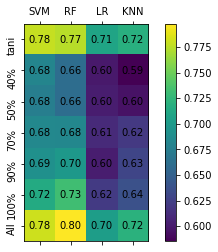

In [27]:
xtick = ['SVM','RF','LR','KNN']
ytick = ['tani','40%','50%','70%','90%','100%','All']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(performances, interpolation='nearest')
fig.colorbar(cax)

for (i, j), z in np.ndenumerate(performances):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax.set_xticklabels(['']+xtick)
ax.set_yticklabels(['']+ytick, rotation=90)

#plt.savefig("/home/poltix/Scrivania/Spyder/phCo_revision/matrix_plotv2.tiff", dpi=300)
plt.show()

In [28]:
visaSVRPerf, viphSVRPerf, saphiSVRPerf
visaRFPerf, viphRFPerf, saphiRFPerf
visaLRPerf, viphLRPerf, saphiLRPerf
visaKNNPerf, viphKNNPerf, saphiKNNPerf  

({'correlation': array([[1.        , 0.62645245],
         [0.62645245, 1.        ]]),
  'errors': array([1.3576552 , 0.43830992, 0.59963819, 0.87752138, 1.25116605,
         2.03298539, 3.74232528, 0.91996436, 2.41454318, 3.45305186,
         2.86800066, 2.73733948, 1.6549818 , 2.60045903, 0.42241752,
         2.54754746, 1.59889377, 0.16959317, 1.12100869, 1.36109695,
         1.88572232, 0.43103469, 1.88972021, 0.34737213, 2.90100337,
         4.19683   , 0.02879717, 2.22039425, 1.55472948, 1.33706443,
         0.17687742, 1.16119646, 1.65608848, 0.14264652, 3.23152244,
         1.21940707, 0.9743613 , 0.31589826, 0.99148458, 0.00689442,
         0.55593307, 0.40324916, 2.00831813, 0.17804577, 2.15308505,
         1.03666026, 2.10942794, 1.25673638, 1.26881544, 2.3694164 ,
         1.40119824, 0.73072251, 1.98697024, 1.4343532 , 1.30563755,
         1.30140486, 1.07692574, 0.74693616, 1.69305878, 1.30133032,
         0.44695897, 1.61720405, 0.13299837, 0.77669193, 0.99343374,
      

([<matplotlib.axis.XTick at 0x7f196f20db00>,
 <a list of 7 Text xticklabel objects>)

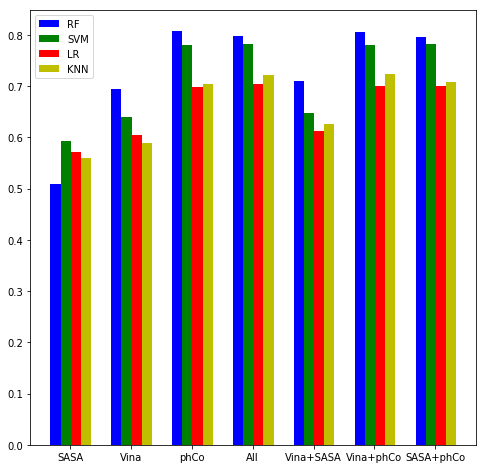

In [29]:
# plotting

rfCorrelation = (SASARFPerf['correlation'][1][0], vinaRFPerf['correlation'][1][0], phCoRFPerf['correlation'][1][0], RFPerf['correlation'][1][0],visaRFPerf['correlation'][1][0],viphRFPerf['correlation'][1][0],saphiRFPerf['correlation'][1][0])
SVMCorrelation = (SASASVRPerf['correlation'][1][0], vinaSVRPerf['correlation'][1][0], phCoSVRPerf['correlation'][1][0], SVRPerf['correlation'][1][0],visaSVRPerf['correlation'][1][0], viphSVRPerf['correlation'][1][0], saphiSVRPerf['correlation'][1][0])
LRCorrelation = (SASALRPerf['correlation'][1][0], vinaLRPerf['correlation'][1][0], phCoLRPerf['correlation'][1][0], LRPerf['correlation'][1][0],visaLRPerf['correlation'][1][0], viphLRPerf['correlation'][1][0], saphiLRPerf['correlation'][1][0])
KNNCorrelation = (SASAKNNPerf['correlation'][1][0], vinaKNNPerf['correlation'][1][0], phCoKNNPerf['correlation'][1][0], KNNPerf['correlation'][1][0],visaKNNPerf['correlation'][1][0], viphKNNPerf['correlation'][1][0], saphiKNNPerf['correlation'][1][0])
SASACorr = [SASARFPerf['correlation'][1][0], SASASVRPerf['correlation'][1][0], SASALRPerf['correlation'][1][0], SASAKNNPerf['correlation'][1][0]]
vinaCorr = [vinaRFPerf['correlation'][1][0], vinaSVRPerf['correlation'][1][0], vinaLRPerf['correlation'][1][0], vinaKNNPerf['correlation'][1][0]]
phCoCorr = [phCoRFPerf['correlation'][1][0], phCoSVRPerf['correlation'][1][0], phCoLRPerf['correlation'][1][0], phCoKNNPerf['correlation'][1][0]]


import matplotlib.pyplot as plt
import numpy as np
#data = [SASACorr, vinaCorr, phCoCorr]
x = np.array([1,2.5,4,5.5,7,8.5,10])
fig,ax = plt.subplots()
#ax = fig.add_axes([0,0,1,1])
plt.gcf().set_size_inches((8, 8))
ax.bar(x+0.00, rfCorrelation, color='b', width=0.25, label='RF')
ax.bar(x+0.25, SVMCorrelation, color='g', width=0.25, label='SVM')
ax.bar(x+0.50, LRCorrelation, color='r', width=0.25, label='LR')
ax.bar(x+0.75, KNNCorrelation, color='y', width=0.25, label='KNN')
ax.legend()
plt.xticks(x + 0.36, ('SASA', 'Vina', 'phCo', 'All', 'Vina+SASA', 'Vina+phCo','SASA+phCo'))
#plt.savefig("/home/poltix/Scrivania/Spyder/phCo_revision/mlShowdown3.pdf")


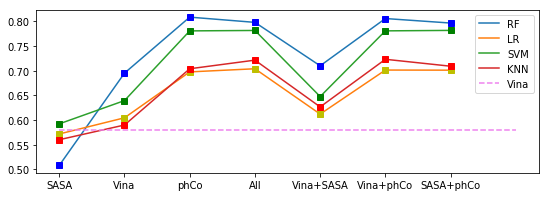

In [45]:
# plotting

rfCorrelation = (SASARFPerf['correlation'][1][0], vinaRFPerf['correlation'][1][0], phCoRFPerf['correlation'][1][0], RFPerf['correlation'][1][0],visaRFPerf['correlation'][1][0],viphRFPerf['correlation'][1][0],saphiRFPerf['correlation'][1][0])
SVMCorrelation = (SASASVRPerf['correlation'][1][0], vinaSVRPerf['correlation'][1][0], phCoSVRPerf['correlation'][1][0], SVRPerf['correlation'][1][0],visaSVRPerf['correlation'][1][0], viphSVRPerf['correlation'][1][0], saphiSVRPerf['correlation'][1][0])
LRCorrelation = (SASALRPerf['correlation'][1][0], vinaLRPerf['correlation'][1][0], phCoLRPerf['correlation'][1][0], LRPerf['correlation'][1][0],visaLRPerf['correlation'][1][0], viphLRPerf['correlation'][1][0], saphiLRPerf['correlation'][1][0])
KNNCorrelation = (SASAKNNPerf['correlation'][1][0], vinaKNNPerf['correlation'][1][0], phCoKNNPerf['correlation'][1][0], KNNPerf['correlation'][1][0],visaKNNPerf['correlation'][1][0], viphKNNPerf['correlation'][1][0], saphiKNNPerf['correlation'][1][0])
SASACorr = [SASARFPerf['correlation'][1][0], SASASVRPerf['correlation'][1][0], SASALRPerf['correlation'][1][0], SASAKNNPerf['correlation'][1][0]]
vinaCorr = [vinaRFPerf['correlation'][1][0], vinaSVRPerf['correlation'][1][0], vinaLRPerf['correlation'][1][0], vinaKNNPerf['correlation'][1][0]]
phCoCorr = [phCoRFPerf['correlation'][1][0], phCoSVRPerf['correlation'][1][0], phCoLRPerf['correlation'][1][0], phCoKNNPerf['correlation'][1][0]]

names = ['SASA', 'Vina', 'phCo', 'All', 'Vina+SASA', 'Vina+phCo','SASA+phCo']
import matplotlib.pyplot as plt
import numpy as np
#data = [SASACorr, vinaCorr, phCoCorr]
x = np.array([1,2.5,4,5.5,7,8.5,10])
plt.figure(figsize=(9,3))
plt.plot(rfCorrelation, label='RF')
plt.plot(LRCorrelation, label='LR')
plt.plot(SVMCorrelation, label='SVM')
plt.plot(KNNCorrelation, label='KNN')
plt.plot(names,rfCorrelation,'sb')
plt.plot(names,SVMCorrelation,'sg')
plt.plot(names,LRCorrelation,'sy')
plt.plot(names,KNNCorrelation,'sr')
xbase = np.linspace(0, len(x))
ybase = 0*xbase+0.58
#axes2 = plt.twinx()
plt.plot(xbase, ybase, color='violet', linestyle = '--', label='Vina')
plt.legend()
# multiple line plot
plt.show
plt.savefig("/home/poltix/Scrivania/Spyder/phCo_revision/mlShowdown4.tiff", DPI=300)


In [39]:
vinaff = np.array([-1*v for v in vinaff])
vinaPerf = getPerformance(vinaff,y_test)

In [40]:
vinaPerf

{'correlation': array([[1.        , 0.58419157],
        [0.58419157, 1.        ]]),
 'errors': array([2.08911335, 2.98513804, 3.11633   , 5.28787784, 2.70739126,
        0.99907126, 3.72559   , 1.11505927, 2.98251   , 3.37967874,
        1.78279732, 3.4768352 , 2.23084291, 1.54752999, 0.25277355,
        2.26048335, 4.76578846, 3.54092647, 0.61660999, 1.32232251,
        1.11389305, 1.82515371, 0.39601   , 0.89199376, 0.99739196,
        4.51933334, 0.98541335, 2.03148587, 0.92328874, 0.48156624,
        3.19622359, 1.45645892, 1.28872376, 1.95807999, 1.40598125,
        1.72527126, 0.36992126, 0.44592696, 2.11739891, 1.6848565 ,
        0.69538075, 1.95174929, 1.31010125, 1.57485251, 3.93890727,
        1.03654394, 0.63020123, 0.39375122, 1.45471664, 2.72688266,
        2.58315999, 1.26047125, 2.03998126, 2.14019251, 2.00162999,
        1.61839268, 0.19676335, 2.43753269, 3.48416359, 2.82569125,
        1.26249901, 0.55288387, 0.81267029, 1.57510392, 1.66852875,
        1.67431251, 3

In [ ]:
phCoRFPerf['correlation'][1][0]

In [ ]:
RFPerf['correlation'][1][0]

In [49]:
pdbbind2016Refined = readCasfIndex("/home/poltix/PDBBindIndexData/PDBBind2016/refinedSetIndex")
X_train2016, y_train2016 = preparingTrainingSet(pdbbind2018Features, affinityLabels, casf2016, mask=pdbbind2016Refined)
rf500 = RandomForestRegressor(n_estimators=500, max_features=0.33, bootstrap=True, oob_score=True, n_jobs=-1)

with open('/home/poltix/Documents/casf2016WMetalIon.pickle', 'rb') as fi:
    casf2016Features = pickle.load(fi)
casf2016 = casf2016Features[casf2016Features['pdb'].isin(casf2016dict.keys())]
casf2016PKD = [affinityLabels[x] for x in casf2016['pdb']]
casf2016_pdb = casf2016['pdb']
casf2016 = casf2016.fillna(0)
casf2016 = casf2016.drop('pdb', axis = 1)
casf2016 = casf2016.drop('Affinity', axis = 1)
for feat in casf2016Features.columns:
    if feat not in X_train2016.columns:
        casf2016Features.drop(feat, axis = 1, inplace = True)
        
casf2016Features = casf2016Features.reindex(sorted(casf2016Features.columns), axis=1)
X_test2016 = casf2016Features
y_test2016 = casf2016PKD
rf500.fit(X_train2016,y_train2016)
prd500 = rf500.predict(X_test2016)
printPerformance(prd500, y_test2016)
rf500.oob_score_

Number of samples in training set 4031
Correlation Coefficient: R=0.988
Accuracy: 92.41
Mean absolute error: 0.4
Standard error of the errors: 0.293
RMSE: 0.499



0.6000456683452091